# MAGICIAN: Mining and gAmblingG servIces sCrapIng and ANalysis

## Setting up the environment for the project


In [1]:
# Required libraris 
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import time



### Configuration for the scraping process


In [2]:
BASE_URL = "https://www.walletexplorer.com"
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/114.0.0.0 Safari/537.36"
    ),
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
    }

### Check the robot.txt file


In [3]:
import urllib.robotparser

# Parse the robots.txt file 
rp = urllib.robotparser.RobotFileParser(BASE_URL + "/robots.txt")
rp.read()

if not rp.mtime() or not rp.can_fetch("*", BASE_URL + "/robots.txt"):
   print("robots.txt could not be read or is not present.")


robots.txt could not be read or is not present.


# Extracting DeepBit.net and DiceOnCrack.com wallet addresses

I create a small pipeline to scrape the walletexplorer website and then extract the wallet addresses from the pages of the two websites by using two functions.
The idea is to firstly scrape the main page of the walletexplorer website and then for each service, scrape the wallet addresses page and extract the addresses from the table. For each request to the walletexplorer website, before proceding I wait 5 seconds to avoid overwhelming the server otherwise I would get ban temporarily from the website.


In [4]:
def get_walletexplorer_page():
    """ 
    Retrieve the main page of WalletExplorer

    This function sends a GET request to the WalletExplorer main page using the specified headers and before sending the request it waits 5 seconds before making the request to avoid overwhelming the server.
    Returns the response object if successful, otherwise returns None.
    """
    try:
        time.sleep(5)  # Pause for 5 seconds to avoid overwhelming the server
        print("Accessing WalletExplorer main page...")
        main_walletexplore_page = requests.get(BASE_URL, headers=HEADERS)
        main_walletexplore_page.raise_for_status()
    except requests.exceptions.RequestException as e:
        print("Error while accessing WalletExplorer:", e)
        return None
    return main_walletexplore_page

def scraping_wallet_address(html_page,service_name):
    """
    Scrape the wallet addresses of a specific service from WalletExplorer.

    This function takes the HTML page of WalletExplorer and the name of the service as input.
    Firstly, it accesses the page of the service by searching for its name, secondly, it navigates to the wallet addresses page and in the end, it extracts the wallet addresses from the table on that page.
    Returns a pandas Series of wallet addresses (hashes) or an empty Series if none are found.

    Parameters:
    - html_page: str, the HTML page of WalletExplorer.
    - service_name: str, the name of the service to search for.
    Returns:
    - pd.Series: a pandas Series containing the wallet addresses (hashes) of the service, or an empty Series if none are found.
    """

    # Open search page regarding 'service_name' and open the wallet addresses page
    try: 
        time.sleep(5)  # Pause for 5 seconds to avoid overwhelming the server
        print(f"Accessing the search page for '{service_name}'...")

        search_page = requests.get(html_page, headers=HEADERS, params={'wallet' :service_name}, timeout=60)
        search_page.raise_for_status()
    except requests.exceptions.RequestException as e:
        print("Error while accessing the search page:", e)
        return None


    # Scrape the search results and extract the wallet addresses of 'service_name'
    soup = BeautifulSoup(search_page.text, 'html.parser')

    # Find the url of the wallet addresses page
    span = soup.find('span', {'class': 'showother'})

    wallet_link = span.find('a').get('href')
    wallets_url = BASE_URL + wallet_link # create the full URL for the wallet addresses page

    # Access the wallet addresses page using the URL found in the search results
    try:
        time.sleep(5)  # Pause for 5 seconds to avoid overwhelming the server        
        wallet_addr_page = requests.get(wallets_url, headers=HEADERS)
        wallet_addr_page.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error while accessing the wallets page: {e}")
        return None     

    # Scrape the wallet addresses page extracting the information from the table
    soup = BeautifulSoup(wallet_addr_page.text, 'html.parser')

    # Save the wallet address of 'service_name'
    tmp = []

    # Find the table containing the wallet addresses
    wallet_table = soup.find('table')

    for row in wallet_table.find_all('tr'):
        col = row.find('td')
        if col and col.find('a', href=True):
            addr = col.find('a')
            tmp.append(addr.text.strip())
    
    return pd.Series(tmp, name='hash') if tmp else pd.Series([], name='hash')

In [5]:
deepbit_service = "DeepBit.net"
diceoncrack_service = "DiceOnCrack.com"

# Open the main page of WalletExplorer
main_walletexplore_page = get_walletexplorer_page()
# Check if the main page was retrieved successfully
if main_walletexplore_page is None:
    print("Failed to retrieve the main WalletExplorer page.")
else:
    # Search the form in the page
    soup = BeautifulSoup(main_walletexplore_page.text, 'html.parser')
    search_form = soup.find('form', {'class':'main'})
    action_form = search_form.get('action')

    # Create the target URL for the search form
    if action_form.startswith('/'):
        target_url = BASE_URL + action_form
    else:
        target_url = BASE_URL+ '/'+action_form


    # Get the wallet addresses for DeepBit.net
    print(f"Searching for wallet addresses of {deepbit_service}...")
    deepbit_wallet_addresses = scraping_wallet_address(target_url, deepbit_service)
    if deepbit_wallet_addresses is None:
        print(f"Failed to retrieve wallet addresses for {deepbit_service}.\n")
    else :
        print(f"Wallet addresses for {deepbit_service} have been successfully retrieved.\n")
    # Get the wallet addresses for DiceOnCrack.com
    print(f"Searching for wallet addresses of {diceoncrack_service}...")
    diceoncrack_wallet_addresses = scraping_wallet_address(target_url, diceoncrack_service)
    if diceoncrack_wallet_addresses is None:
        print(f"Failed to retrieve wallet addresses for {diceoncrack_service}.\n")
    else :
        print(f"Wallet addresses for {diceoncrack_service} have been successfully retrieved.\n")
#Print the results
print(f"DeepBit.net wallet addresses:\n {deepbit_wallet_addresses}")
print(f"DiceOnCrack.com wallet addresses:\n {diceoncrack_wallet_addresses}")


Accessing WalletExplorer main page...
Searching for wallet addresses of DeepBit.net...
Accessing the search page for 'DeepBit.net'...
Wallet addresses for DeepBit.net have been successfully retrieved.

Searching for wallet addresses of DiceOnCrack.com...
Accessing the search page for 'DiceOnCrack.com'...
Wallet addresses for DiceOnCrack.com have been successfully retrieved.

DeepBit.net wallet addresses:
 0     1VayNert3x1KzbpzMGt2qdqrAThiRovi8
1    13NGmRF2SVRg3aKdGNVhXLmhA1JT9p87a8
Name: hash, dtype: object
DiceOnCrack.com wallet addresses:
 0     12TaAbLWBNKB1NLYH92CPnC1DizQoNK6FN
1     1CRACkbiJSxfDaLNEoaNsHjNtU4KttwHyo
2     1CRACKafkXsQzUYmu2fUM3j9c2y4yDhvfh
3     1CRACKLiwFrZbAQz1yb9w22onHCMLbiMTY
4     12tAabLFLxvUzC5KuX7VKMM8bYRncbQ84E
5     1CrAcKt3HE8LNsx4KKDvjqLvcr373wg5ke
6     1AVFypuG2jUrYzjZa69C7hK59XkWUwvK1m
7     1CRACK25QvpVdcEmPZVD5ixtf99cMF9stg
8     1CracksLRtQMcTF4HXNrvPzRgvz7Qr6wNd
9     13TAabLHjNzwg8Mj7XYn76FuVAqj32s8EM
10    1CrAckQppdcfiiw4XzpsKrZrf9eDvUok9C

#### Load datasets for the next analysis regarding the service DeepBit.net and DiceOnCrack.com

Given that the great size of the datasets, I decided to read the csv files only one time in order to avoid to read them multiple times during the analysis. I used Pyarrow engine to read the csv files due to its speed and efficiency in handling large datasets.


In [6]:
# Load datasets
transactions = pd.read_csv('transactions.csv', engine='pyarrow')
transactions.columns = ['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee']

outputs = pd.read_csv('outputs.csv', engine='pyarrow')
outputs.columns = ['txId', 'position', 'addressId', 'amount', 'scripttype']

inputs = pd.read_csv('inputs.csv', engine='pyarrow')
inputs.columns = ['txId', 'prevTxId', 'prevTxpos']

mapping = pd.read_csv('mapping.csv', engine='pyarrow')
mapping.columns = ['hash', 'addressId']

# Deepbit.net's mining pool analysis

Subsequently, I will analyze the dataset of the Deepbit.net mining pool. The analysis will focus on the distribution of the mined blocks, the distribution of the received fees and the computation of the UTXO (Unspent Transaction Output) regarding the service Deepbit.net


In [7]:
def map_wallet_addresses(wallet_addresses,mapping_dt):
    """
    Map the wallet addresses to their corresponding addressId in the mapping dataset.
    Returns a Series of addressId found or an empty Series if none found.

    Parameters:
    - wallet_addresses: pd.Series, a Series of wallet addresses (hashes) to be mapped.
    - mapping_dt: pd.DataFrame, a DataFrame containing the mapping of wallet addresses to addressId.
    Returns:
    - pd.Series: a pandas Series containing the addressId corresponding to the wallet addresses, or an empty Series if none are found.
    """
    mapped_addresses = mapping_dt.merge(wallet_addresses,on ='hash')['addressId']
    if mapped_addresses.empty:
        return pd.Series([], name='addressId')
    
    return mapped_addresses 

In [8]:
#1) Identify the mapping between wallet addresses on the dataset
deepbit_mapped_addresses = map_wallet_addresses(deepbit_wallet_addresses,mapping)

print(deepbit_mapped_addresses.head())


0    2536929
1    2537090
Name: addressId, dtype: int64


## 1) Deepbit.net's mined block distribution


Firslty, it needs to extract the transactions of DeepBit.net from the datasets, which are the transactions that have at least one input or output address of DeepBit.net.


In [9]:
def find_wallet_transactions(wallet_mapped_addresses, transactions, inputs, outputs):
    """
    Finds all transactions related to the specified service addresses.
    This function takes the mapped addresses of a service and the transactions, inputs, and outputs datasets and the retrieves all transactions that have at least one output address of the service.
    It returns a DataFrame containing all transaction details related to the service.

    Parameters:
    - wallet_mapped_addresses: pd.Series, a Series of addressId corresponding to the wallet
    addresses of the service.
    - transactions: pd.DataFrame, a DataFrame containing transaction details.
    - inputs: pd.DataFrame, a DataFrame containing input details of transactions.
    - outputs: pd.DataFrame, a DataFrame containing output details of transactions.
    Returns:
    - pd.DataFrame: a DataFrame containing all transaction details related to the service.
    """

    # Find all outputs information (address, amount, ...) regardin the service
    diceoncrack_output_transactions = outputs.merge(wallet_mapped_addresses,on='addressId') 
    
    # Find all inputs information (address, amount, ...) regarding the service and rename the columns to prepare for the merge between inputs and outputs dataframes
    renamed_outputs= diceoncrack_output_transactions.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'})
    wallet_input_transactions = inputs.merge(renamed_outputs,on=['prevTxId', 'prevTxpos'])

    # Make the union of all transactions that have at least one output address of the service
    df_union = pd.concat([diceoncrack_output_transactions['txId'], wallet_input_transactions['txId']], axis=0,ignore_index=True).drop_duplicates().reset_index(drop=True)

    # Merge the union of transactions with the transactions dataset to get all transaction details
    wallet_transactions = transactions.merge(df_union,on='txId') 

    return wallet_transactions


# Find the transactions related to Deepbit.net
deepbit_transactions = find_wallet_transactions(deepbit_mapped_addresses, transactions, inputs, outputs)

### Find the distribution of the mined blocks by DeepBit.net in the dataset


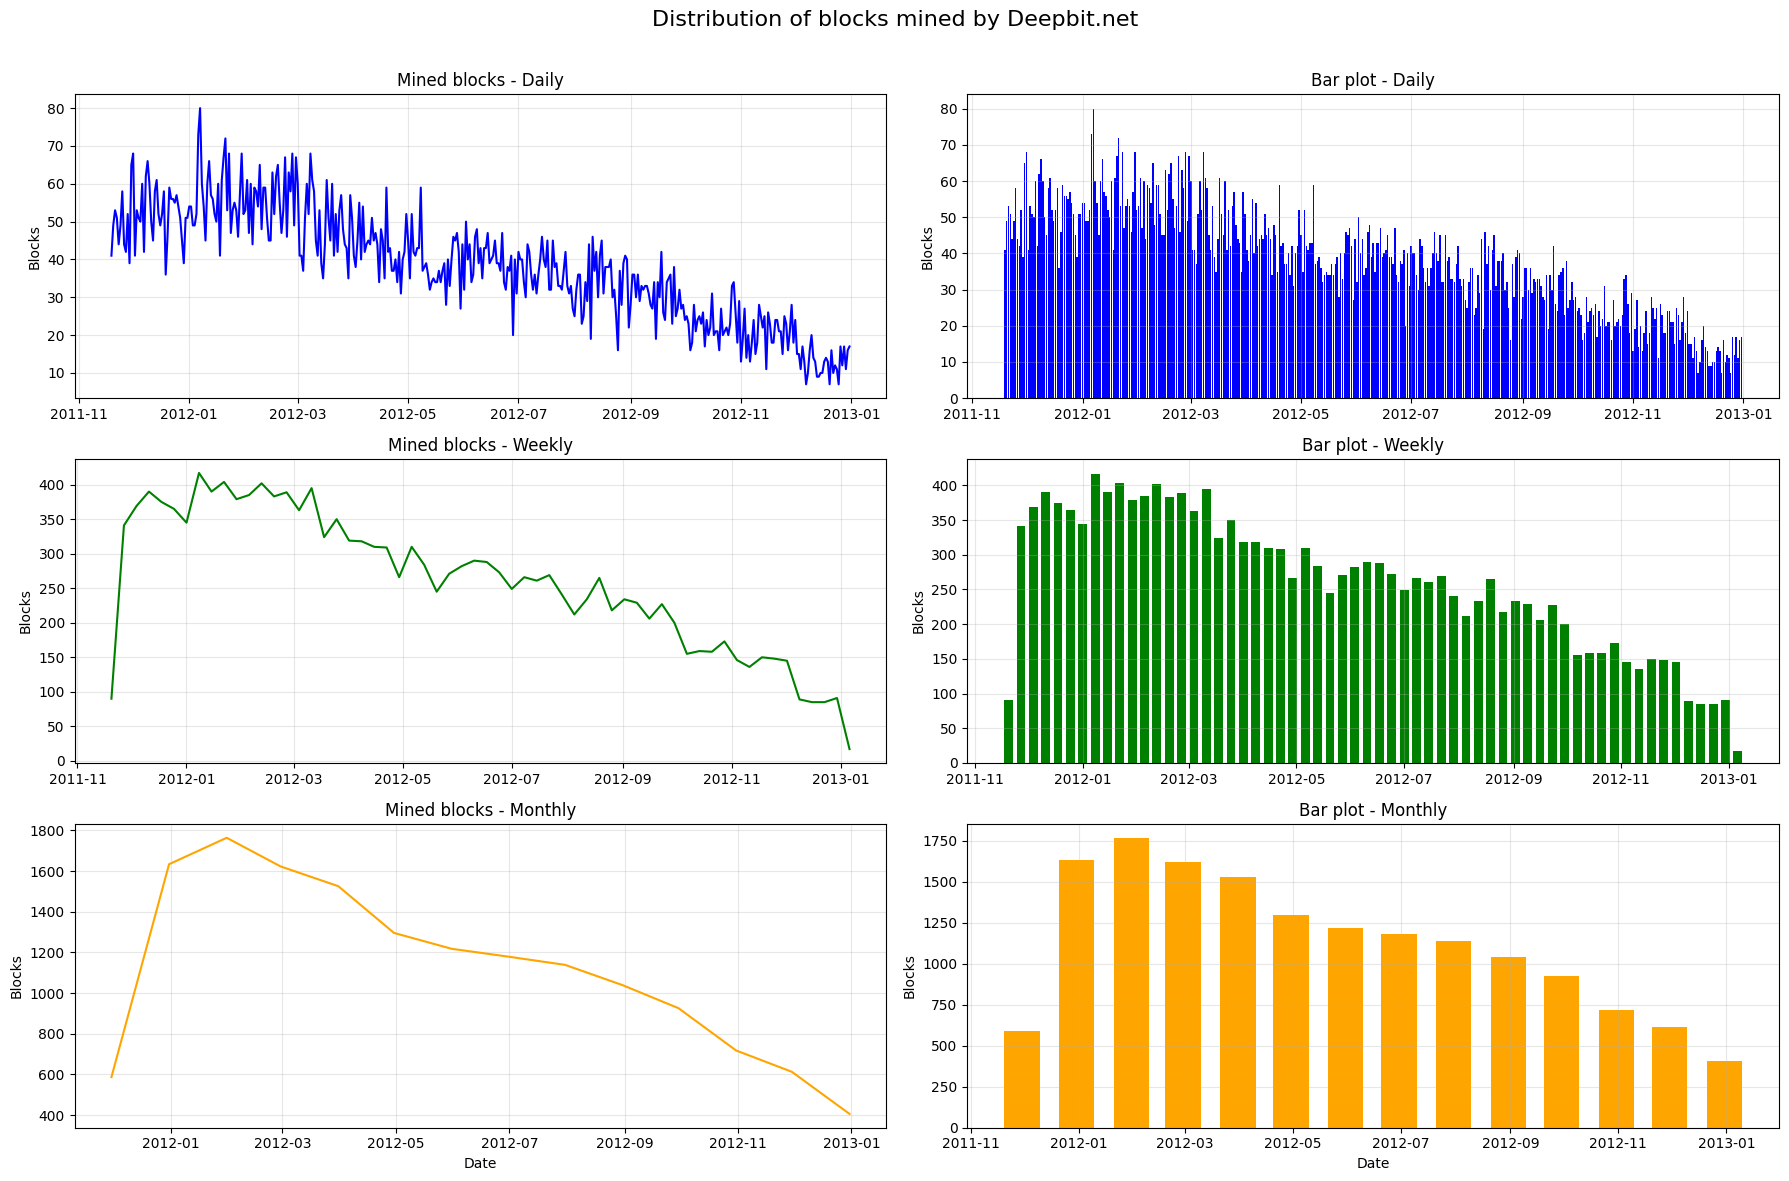

In [10]:
# Find the transaction patterns for the wallet addresses

# 1. Select all coinbase transactions (mining rewards) from the transactions dataset and merge them with the outputs dataset in order to get their output information 
coinbase_transactions = transactions[transactions['isCoinbase'] == 1]['txId']
merged_outputs_first_transact= outputs.merge(coinbase_transactions, on='txId')

# 2. Find all outputs where Deepbit.net addresses appear (as outputs)
deepbit_asoutput_transactions = outputs.merge(deepbit_mapped_addresses, on='addressId')
tmp = deepbit_asoutput_transactions.merge(deepbit_transactions, on='txId')
inputs_second_transaction = tmp.merge(inputs, on='txId')

# Merge to find the base pattern: transactions where Deepbit.net spends outputs from mined blocks
merged_outputs_first_transact.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'}, inplace=True)
deepbit_mined_block_transact = inputs_second_transaction.merge(merged_outputs_first_transact, on=['prevTxId', 'prevTxpos']).drop_duplicates()[['txId', 'prevTxId', 'prevTxpos','timestamp']]

# Lets prepare the data for Deepbit.net block distribution
deepbit_block_distribution = deepbit_mined_block_transact.copy()
deepbit_block_distribution['timestamp'] = pd.to_datetime(deepbit_block_distribution['timestamp'], unit='s')
deepbit_block_distribution.set_index('timestamp', inplace=True)

# 1. Daily count
daily = deepbit_block_distribution.resample('D').size()
# 2. Weekly count
weekly = deepbit_block_distribution.resample('W').size()
# 3. Monthly count
monthly = deepbit_block_distribution.resample('ME').size()

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Distribution of blocks mined by Deepbit.net', fontsize=16)

# Line plots (left)
axs[0, 0].plot(daily.index, daily.values, label='Daily', color='blue')
axs[0, 0].set_title('Mined blocks - Daily')
axs[0, 0].set_ylabel('Blocks')
axs[0, 0].grid(True, alpha=0.3)

axs[1, 0].plot(weekly.index, weekly.values, label='Weekly', color='green')
axs[1, 0].set_title('Mined blocks - Weekly')
axs[1, 0].set_ylabel('Blocks')
axs[1, 0].grid(True, alpha=0.3)

axs[2, 0].plot(monthly.index, monthly.values, label='Monthly', color='orange')
axs[2, 0].set_title('Mined blocks - Monthly')
axs[2, 0].set_ylabel('Blocks')
axs[2, 0].set_xlabel('Date')
axs[2, 0].grid(True, alpha=0.3)

# Bar plots (right)
axs[0, 1].bar(daily.index, daily.values, color='blue')
axs[0, 1].set_title('Bar plot - Daily')
axs[0, 1].set_ylabel('Blocks')
axs[0, 1].grid(True, alpha=0.3)

axs[1, 1].bar(weekly.index, weekly.values, color='green', width=5)
axs[1, 1].set_title('Bar plot - Weekly')
axs[1, 1].set_ylabel('Blocks')
axs[1, 1].grid(True, alpha=0.3)

axs[2, 1].bar(monthly.index, monthly.values, color='orange', width=20)
axs[2, 1].set_title('Bar plot - Monthly')
axs[2, 1].set_ylabel('Blocks')
axs[2, 1].set_xlabel('Date')
axs[2, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## 2) DeepBit.net's fee distribution

Find how fee transactions are distributed to the DeepBit.net's mining pool


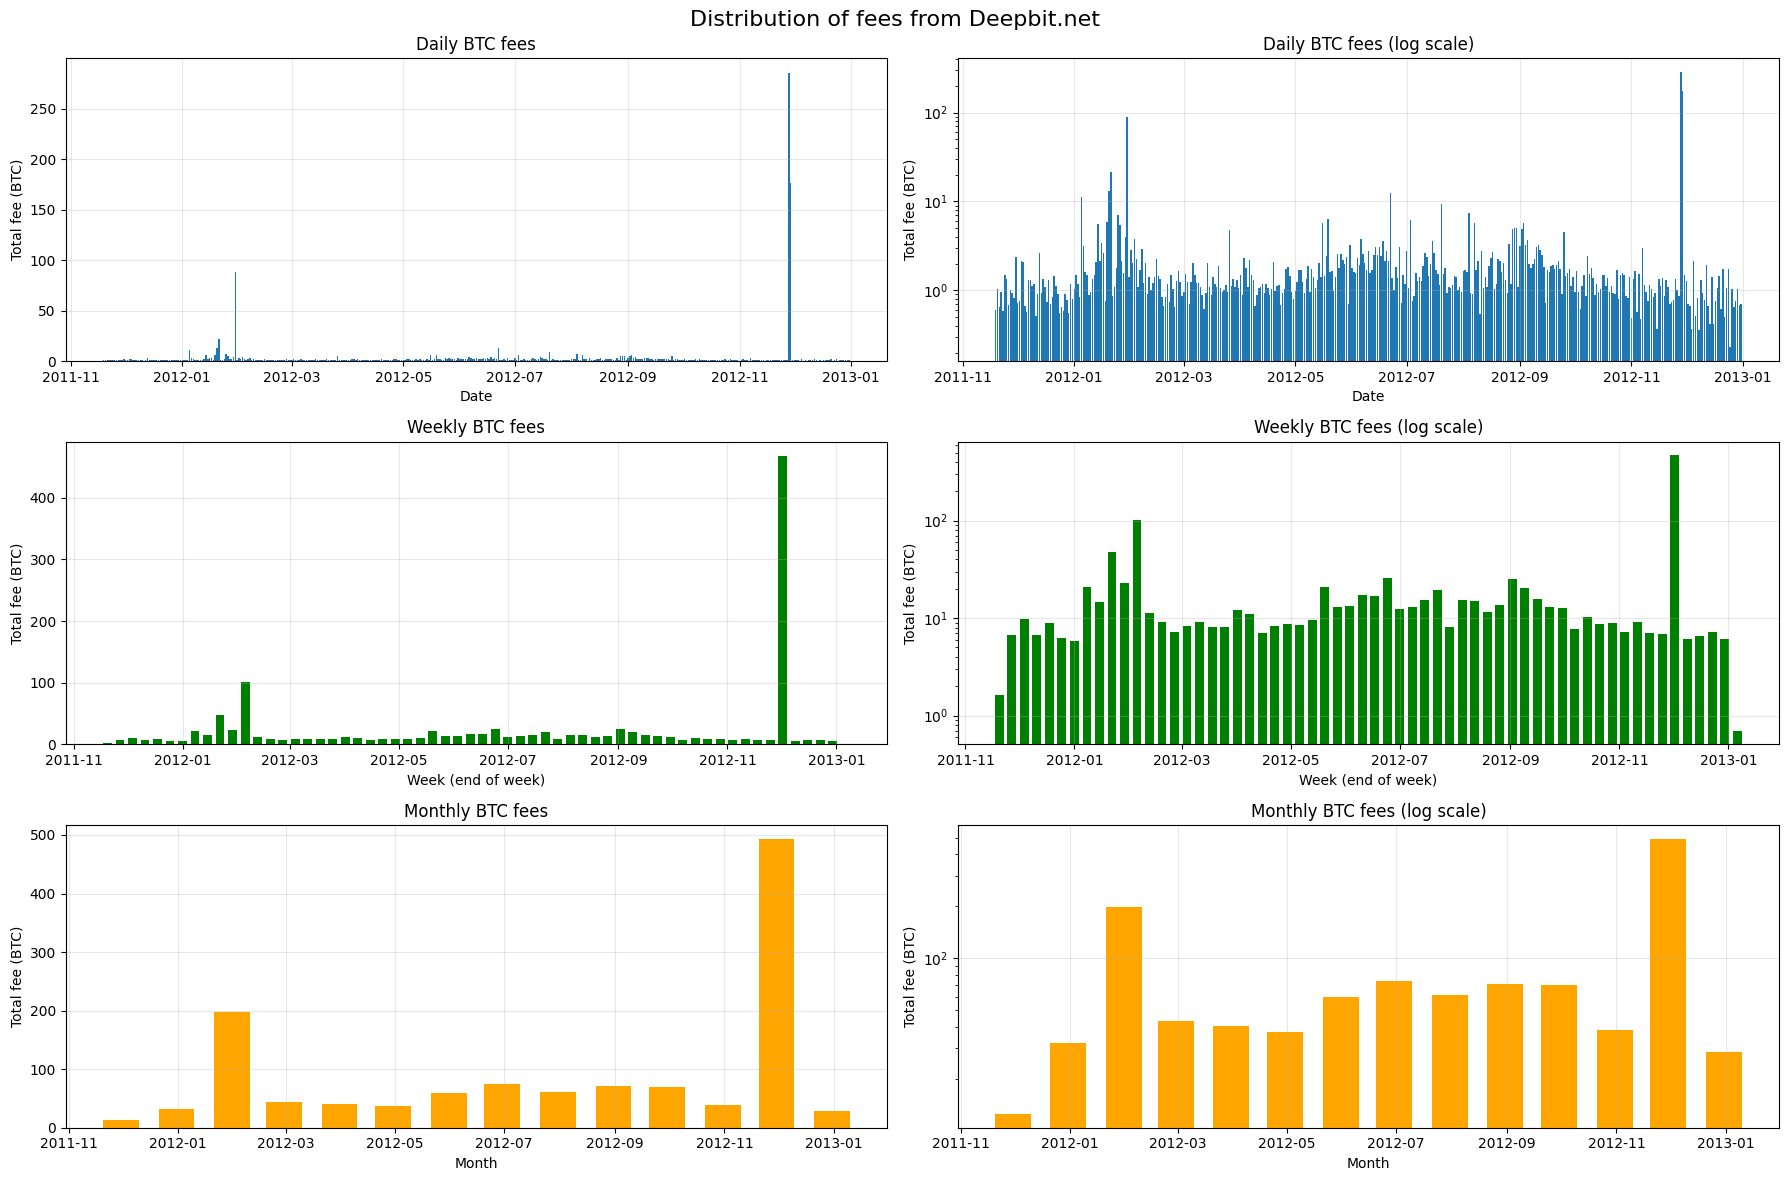

In [11]:
# Identify coinbase transactions information
renamed_outputs = outputs.copy()
renamed_outputs.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'}, inplace=True)
fee_info= renamed_outputs.merge(deepbit_mined_block_transact, on=['prevTxId','prevTxpos']).merge(transactions[['txId', 'blockId', 'fee']], on='txId')

# Convert timestamp to datetime and create a time series
fee_info['timestamp'] = pd.to_datetime(fee_info['timestamp'], unit='s')
fee_info.set_index('timestamp', inplace=True)

# Define the blockId of the first Bitcoin halving event.
first_btc_halving_blockId = 210000
# Convert the output amount from satoshis to BTC
fee_info['amount'] = fee_info['amount'] / 1e8  

# Calculate the expected block reward (50 BTC before halving, 25 BTC after) and compute the actual fee in BTC for each mined block transaction
fee_subtract = (fee_info['blockId'] < first_btc_halving_blockId).map({True: 50, False: 25})
fee_info['fee_btc'] = (fee_info['amount']+fee_info['fee'] - fee_subtract).round(8)


# Aggregations
daily_fee   = fee_info['fee_btc'].resample('D').sum()
weekly_fee  = fee_info['fee_btc'].resample('W').sum()
monthly_fee = fee_info['fee_btc'].resample('ME').sum()

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Distribution of fees from Deepbit.net', fontsize=16)

# Daily bar plot
axs[0,0].bar(daily_fee.index, daily_fee.values)
axs[0,0].set_title('Daily BTC fees')
axs[0,0].set_xlabel('Date')
axs[0,0].set_ylabel('Total fee (BTC)')
axs[0,0].grid(True, alpha=0.3)

# Weekly bar plot
axs[1,0].bar(weekly_fee.index, weekly_fee.values, color='green', width=5)
axs[1,0].set_title('Weekly BTC fees')
axs[1,0].set_xlabel('Week (end of week)')
axs[1,0].set_ylabel('Total fee (BTC)')
axs[1,0].grid(True, alpha=0.3)

# Monthly bar plot
axs[2,0].bar(monthly_fee.index, monthly_fee.values, color='orange', width=20)
axs[2,0].set_title('Monthly BTC fees')
axs[2,0].set_xlabel('Month')
axs[2,0].set_ylabel('Total fee (BTC)')
axs[2,0].grid(True, alpha=0.3)

# Daily bar plot (log scale)
axs[0,1].bar(daily_fee.index, daily_fee.values)
axs[0,1].set_yscale('log')
axs[0,1].set_title('Daily BTC fees (log scale)')
axs[0,1].set_xlabel('Date')
axs[0,1].set_ylabel('Total fee (BTC)')
axs[0,1].grid(True, alpha=0.3)

# Weekly bar plot (log scale)
axs[1,1].bar(weekly_fee.index, weekly_fee.values, color='green', width=5)
axs[1,1].set_yscale('log')
axs[1,1].set_title('Weekly BTC fees (log scale)')
axs[1,1].set_xlabel('Week (end of week)')
axs[1,1].set_ylabel('Total fee (BTC)')
axs[1,1].grid(True, alpha=0.3)

# Monthly bar plot (log scale)
axs[2,1].bar(monthly_fee.index, monthly_fee.values, color='orange', width=20)
axs[2,1].set_yscale('log')
axs[2,1].set_title('Monthly BTC fees (log scale)')
axs[2,1].set_xlabel('Month')
axs[2,1].set_ylabel('Total fee (BTC)')
axs[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3) DeepBit.net's UTXO distribution

Compute the UTXO (Unspent Transaction Output) distribution of the DeepBit.net for each month in the dataset


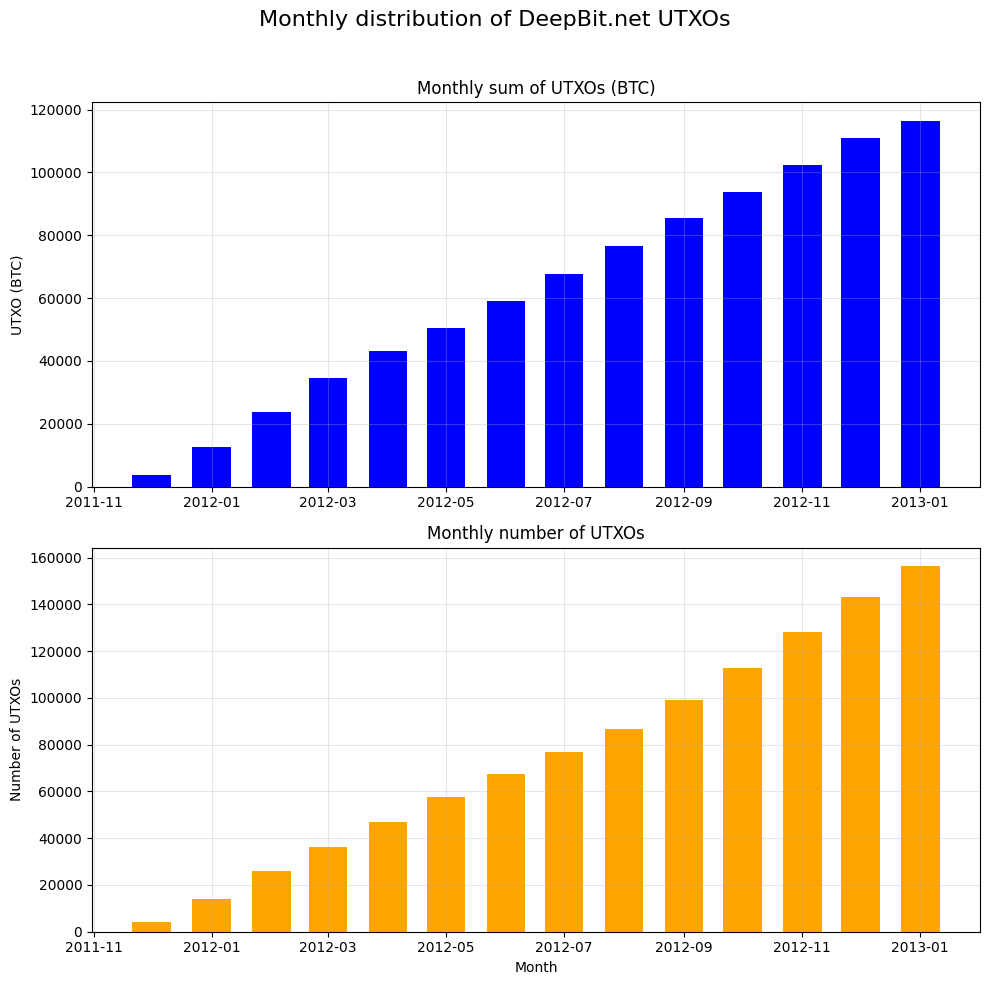

In [12]:
# UTXO are related to the unspent outputs of a transaction.

# Merge DeepBit.net related transactions with outputs to get all outputs with their timestamps
utxo_transactions = outputs.copy().merge(deepbit_transactions[['txId', 'timestamp']], on='txId')
utxo_transactions.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'}, inplace=True)

# Merge with inputs to check which outputs have been spent
spent_utxo = utxo_transactions.merge(inputs[['prevTxId', 'prevTxpos']],on=['prevTxId', 'prevTxpos'], how='left', indicator='is_spent')

# Identify unspent outputs (UTXO)
unspent_utxo = spent_utxo[spent_utxo['is_spent'] == 'left_only'].drop(columns=['is_spent'])

# Convert the amount from satoshis to BTC and the timestamp to datetime.
unspent_utxo['amount'] = unspent_utxo['amount'] / 1e8 
unspent_utxo['timestamp'] = pd.to_datetime(unspent_utxo['timestamp'], unit='s')

# Create a range of month-end dates covering the period of the UTXOs.
all_dates = pd.date_range(
    start=unspent_utxo['timestamp'].min().to_period('M').to_timestamp(),
    end=unspent_utxo['timestamp'].max(),
    freq='ME'
)
# Adjust the end of the month to include the last second of the month (for example, 2011-11-31 23:59:59)
all_dates = all_dates.floor('D') + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

# Calculate monthly UTXO
# For each month, calculate the sum and count of UTXOs available before the end of that month.
monthly_utxo =[]
for month_end in all_dates:
    before_month_end_utxo = unspent_utxo[unspent_utxo['timestamp'] < month_end]
    sum_utxo_btc = before_month_end_utxo['amount'].sum()
    utxo_count = before_month_end_utxo['amount'].count()
    monthly_utxo.append([month_end, sum_utxo_btc, utxo_count])

monthly_utxo_df = pd.DataFrame(monthly_utxo, columns=['month', 'utxo_btc', 'utxo_count'])

# Visualize the monthly UTXO using bar plots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle('Monthly distribution of DeepBit.net UTXOs', fontsize=16)

# Bar plot UTXO BTC
axs[0].bar(monthly_utxo_df['month'], monthly_utxo_df['utxo_btc'], color='blue', width=20, align='center')
axs[0].set_ylabel('UTXO (BTC)')
axs[0].set_title('Monthly sum of UTXOs (BTC)')
axs[0].grid(True, alpha=0.3)

# Bar plot UTXO Count
axs[1].bar(monthly_utxo_df['month'], monthly_utxo_df['utxo_count'], color='orange', width=20, align='center')
axs[1].set_ylabel('Number of UTXOs')
axs[1].set_title('Monthly number of UTXOs')
axs[1].set_xlabel('Month')
axs[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Deepbit.net chain of transactions

Let's create a graph of the transactions of Deepbit.net starting from the transaction _1883820_ in the dataset and start following the chain of transactions where a Deepbit.net address is present as output address. The graph will be created using NetworkX library.


Preparing the data for the graphs of DeepBit.net


In [13]:
import networkx as nx

# Find the transaction with txId 1883820
transaction = transactions[transactions['txId'] == 1883820].merge(outputs, on='txId')

## 1) Create a graph of the transactions of DeepBit.net following the chain of transactions

Starting from the transaction _1883820_ in the dataset, I will follow the chain of transactions where a Deepbit.net address is present as output address. When I find a transaction with a Deepbit.net address as output address, I will add the transaction to the graph and continue to follow the chain of transactions saving the change address as label of the edge and saving, if presents, the other output addresses. When it finds a transaction with no Deepbit.net address or with more than one Deepbit.net address, it stops the process and prints the number of transactions in the graph and the number of addresses that do not belong to Deepbit.net. In the meanwhile it prints the sequence of transactions in the graph and the change addresses as labels of the edges.


In [14]:
# Inizialize a directed graph to represent the transaction chain
deepbit_graph = nx.MultiDiGraph()

# Add the first transaction to the graph
deepbit_graph.add_node(transaction.iloc[0]['txId'])

# Optimize the output and input information to only include transactions with txId greater than or equal to the current transaction
output_info = outputs[outputs['txId'] >= transaction.iloc[0]['txId']].copy()
inputs_info = inputs[inputs['txId'] >= transaction.iloc[0]['txId']].copy()


current_transaction = transaction

OthersDeepbit =set() # outputs not belonging to Deepbit.net
other_outputs_per_tx = dict()

while True:
    # Find the inputs for the current transaction
    outs = output_info.merge(current_transaction['txId'], on='txId')
    
    # Check if there is a Deepbit.net address in the outputs of the current transaction
    check_deepbit_addr= outs.merge(deepbit_mapped_addresses, on='addressId', how='left', indicator='is_deepbit').rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'})
    deepbit_addrs = check_deepbit_addr[check_deepbit_addr['is_deepbit'] == 'both']
    other_addrs = check_deepbit_addr[check_deepbit_addr['is_deepbit'] == 'left_only']

    # If there are no Deepbit.net addresses in the outputs, stop the process
    if len(deepbit_addrs) !=1 :
        print(f"Stop the process: no Deepbit.net change-address are present in tx {current_transaction.iloc[0]['txId']} as ouptput address.\n")
        break
    if not other_addrs.empty:
        # Add the outputs that do not belong to Deepbit.net to the set
        OthersDeepbit.update(other_addrs['addressId'].unique())
        other_outputs_per_tx[current_transaction.iloc[0]['txId']] = mapping[mapping['addressId'].isin(other_addrs['addressId'])]['hash'].to_list()
    
    # Find the next transaction
    next_transactions = inputs_info.merge(deepbit_addrs, on=['prevTxId', 'prevTxpos'])
    if next_transactions.empty:
        print(f"Stop the process: the chain of transactions stops at the transaction {current_transaction['txId']}\n")
        break
    # Add the next transaction to the graph
    next_tx_id = next_transactions.iloc[0]['txId']
    deepbit_graph.add_node(next_tx_id)
    
    current_tx_id = current_transaction.iloc[0]['txId']
    change_address = mapping[mapping['addressId']==deepbit_addrs.iloc[0]['addressId']].iloc[0]['hash']  # change address
    
    # Add an edge from the current transaction to the next transaction
    deepbit_graph.add_edge(current_tx_id,next_tx_id, change_address=change_address)

    # Update the current transaction to the next one
    current_transaction = next_transactions

print(f"Total number of transactions in the graph: {deepbit_graph.number_of_nodes()}\n")
print(f"Number of OthersDeepbit addresses: {len(OthersDeepbit)}")

Stop the process: no Deepbit.net change-address are present in tx 1884845 as ouptput address.

Total number of transactions in the graph: 71

Number of OthersDeepbit addresses: 68


Text(0.5, 1.0, 'Chain of transaction of DeepBit.net')

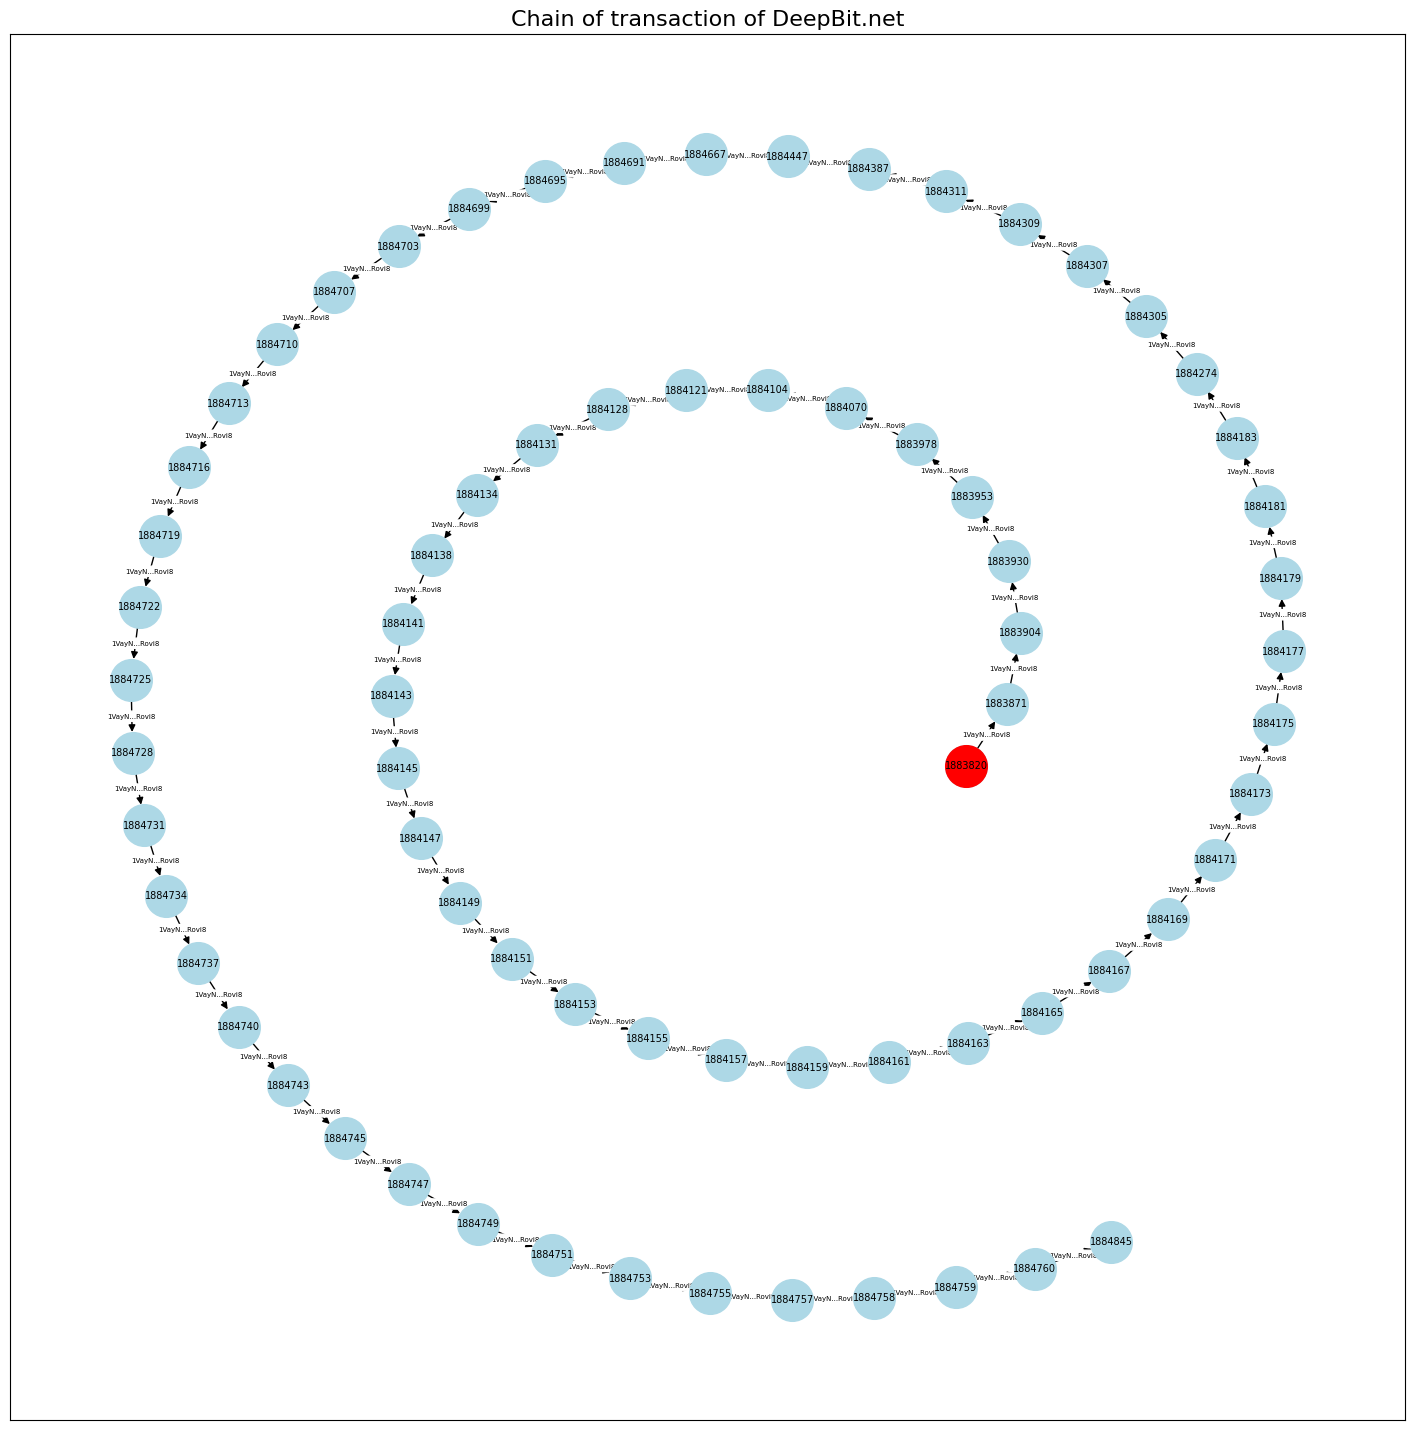

In [15]:
def abbreviate_label(label):
    """
    Abbreviates a label string for better visualization on the graph.
    Shows the first 5 and last 5 characters separated by '...'.
    """
    label_str = str(label)
    return f"{label_str[:5]}...{label_str[-5:]}"


# Create edge labels for the graph, abbreviating the change address for readability.
edge_labels = {
    (u, v): abbreviate_label(
        d['change_address'].values[0] if hasattr(d['change_address'], 'values') else d['change_address']
    )
    for u, v, d in deepbit_graph.edges(data=True)
}

# Generate a spiral layout for the graph nodes for better visualization.
graph_spiral_layout = nx.spiral_layout(deepbit_graph, equidistant=True, resolution=5, scale=100)

# Draw the full transaction graph with nodes and edges.
plt.figure(figsize=(18, 18))
nx.draw_networkx(deepbit_graph, pos=graph_spiral_layout, node_color='lightblue', font_size=7, font_color='black', arrows=True, node_size=900)
nx.draw_networkx_nodes(deepbit_graph, nodelist=[list(deepbit_graph.nodes())[0]], node_color='red', node_size=900, label='Start Node', pos=graph_spiral_layout)
nx.draw_networkx_edge_labels(deepbit_graph, pos=graph_spiral_layout, edge_labels=edge_labels, font_size=5, rotate=False)

plt.title('Chain of transaction of DeepBit.net', fontsize=16)

## 2) Computing the differences between the timestamps and the values sent on change addresses

For each pair of transactions ti, ti+1 in the chain, calculate the difference between the timestamps of the two transactions and between the values sent on change addresses, and visualize the differences obtained on a graph.


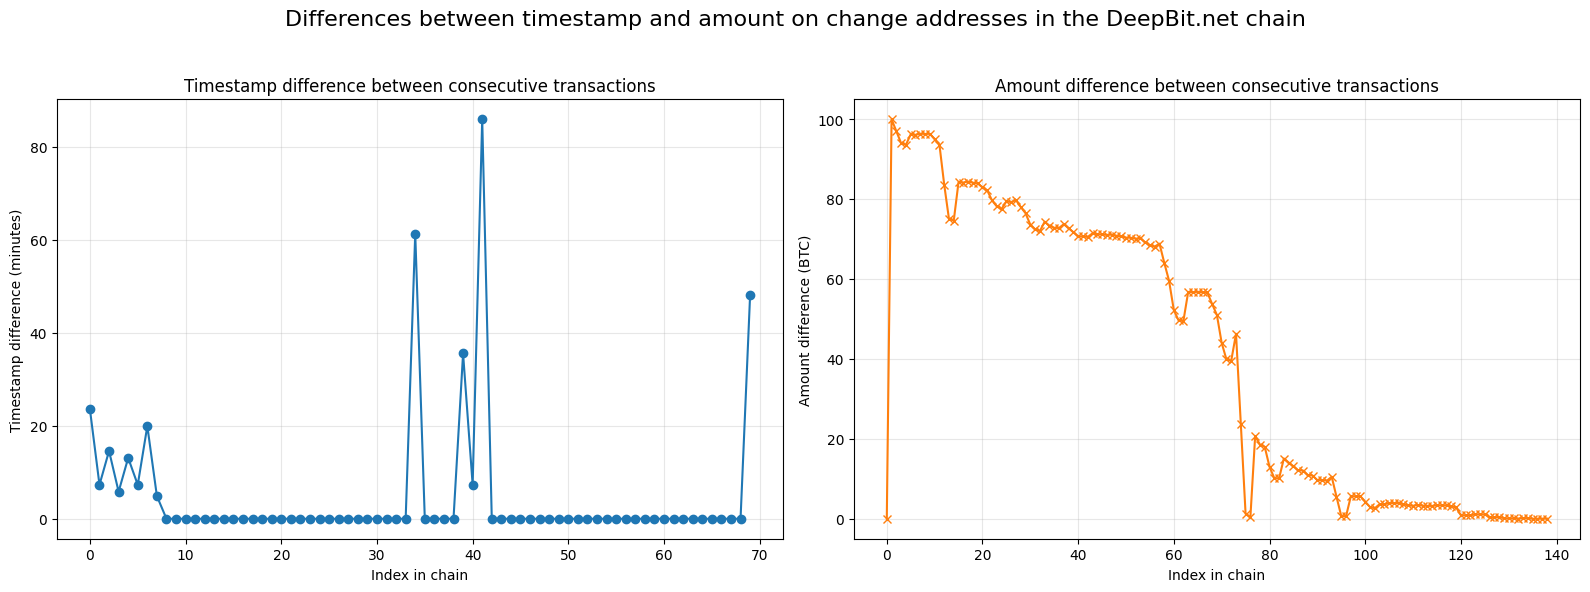

In [16]:
# Create a Series with the transaction IDs in the DeepBit.net chain
txId_chain = pd.Series(list(deepbit_graph.nodes()), name='txId')

# Merge the transaction timestamps with the chain of txIds
payment_info = transactions[['timestamp', 'txId']].merge(txId_chain, on='txId').reset_index()

# Compute the differences between consecutive timestamps
diff_timestamp = pd.Series(payment_info['timestamp'].diff().shift(-1)/60, name='timestamp_diff').round(2)

# Compute the differences between consecutive amounts on change addresses
amount_info = outputs.merge(payment_info, on='txId')
amount_diff = pd.Series(amount_info['amount'].diff().shift(-1).abs() / 1e8, name='amount_diff')

# Plot the differences
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Differences between timestamp and amount on change addresses in the DeepBit.net chain', fontsize=16)

# First subplot: timestamp difference
axs[0].plot(diff_timestamp.index, diff_timestamp, color='tab:blue', marker='o')
axs[0].set_title('Timestamp difference between consecutive transactions')
axs[0].set_xlabel('Index in chain')
axs[0].set_ylabel('Timestamp difference (minutes)')
axs[0].grid(True, alpha=0.3)

# Second subplot: amount difference
axs[1].plot(amount_diff.index, amount_diff, color='tab:orange', marker='x')
axs[1].set_title('Amount difference between consecutive transactions')
axs[1].set_xlabel('Index in chain')
axs[1].set_ylabel('Amount difference (BTC)')
axs[1].grid(True, alpha=0.3)
# axs[1].ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis if needed

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 3) OtherDeepbit addresses De-anonymization

In this part, I will analyze the addresses that do not belong to Deepbit.net, which I will call OthersDeepbit. The goal is to de-anonymize these addresses by checking if they correspond to entities that have been de-anonymized on WalletExplorer through the help of the scraping process.


In [17]:
REQUEST_INTERVAL = 5  # secondi tra le richieste
WALLET_SCRAPING_CACHE = {}

def is_deanonymized(address):
    """
    Checks if a Bitcoin address has been de-anonymized on WalletExplorer.

    This function performs a web scraping request to WalletExplorer for the given address. In order to avoid overwhelming the server,
    a cache is used to store previously checked addresses. Indeed, if the address is found in the local cache, it returns the cached result.
    Otherwise, it queries the WalletExplorer website, parses the result, and determines if the address is labeled (de-anonymized) or not.
    The result is cached for future calls.

    Parameters:
        address (str): The address to check.

    Returns:
        bool or None: Returns True if the address is de-anonymized (labeled), False if not,
                      or None if the status cannot be determined (e.g., scraping error).
    """
    # Check if the address is already in the cache
    if address in WALLET_SCRAPING_CACHE:
        return WALLET_SCRAPING_CACHE[address]
    
    # Construct the URL for the address search
    url = f"{BASE_URL}/?q={address}"
    
    try:
        # Wait between requests to avoid being blocked
        time.sleep(REQUEST_INTERVAL)  
        
        response = requests.get(url, headers=HEADERS, timeout=50)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Try to find the wallet label in the main div
        main_div = soup.find('div', id='main')
        h2_tag = main_div.find('h2') if main_div else None
        
        if h2_tag:
            # Get the full text and split by spaces
            full = h2_tag.get_text(separator=' ').strip()
            quoted = full.split(' ')
            cleaned = [s.strip() for s in quoted]
            if len(cleaned) >= 2:
                wallet_hash = cleaned[2]
                # If the wallet hash is not enclosed in brackets, it's not labeled
                if wallet_hash[0] != '[' and wallet_hash[-1] != ']':
                    return False
                WALLET_SCRAPING_CACHE[address] = True
                return True
        
        # If not found, return None
        return None
        
    except Exception as e:
        print(f"Error during scraping for {address}: {str(e)}")
        return None
    
# Map the addressId of the other addresses to their corresponding hashes
otheraddresses_mapped = mapping.merge(pd.Series(list(OthersDeepbit), name='addressId'), on='addressId')['hash']

# Check which are the deanonymized addresses
deanonymized_addresses = set()
for address in otheraddresses_mapped:
    res = is_deanonymized(address)
    if res is not None and res:
        deanonymized_addresses.add(address)
        print(f"Address {address} is deanonymized.")

print(f"Total deanonymized addresses: {len(deanonymized_addresses)}")



Address 1BC1QZyEc7Rs7DJEZbYk52Wx3FUNoJkTbH is deanonymized.
Address 1M3vQswJNsaQTpZfETkUBiaBC39QLeZuWE is deanonymized.
Address 17qLXF6cLYg31cPbMQhRt8ZEeL4Rj7sVmV is deanonymized.
Address 12ys4qSPDtKi9mgdFTxb57gZSBthNdPhFS is deanonymized.
Address 18YzZXbnTPFhtH5Mv5KcGKbduUX1w67xos is deanonymized.
Address 1MVtDAKuy79VyiRgHbFd4MuEgseAheJxyd is deanonymized.
Address 19ULqZSRFAnMMgwJqU3acDYWzbyCBmaKvN is deanonymized.
Address 1LJiKfFYQdmPYozab6wdbEhJ95kvLTxBhU is deanonymized.
Address 1BF5k3zbvvWrGb1fXwQWU3LZLWpsZ3VBcG is deanonymized.
Address 1KFnK5dbLGUxMPmgvLPHVfLrXzFSMxgbsg is deanonymized.
Address 1MbMktiA2kn5fy7HzwGoWW6eNHiN61QatG is deanonymized.
Address 1CqWkeHGfmqZkDqoXZDDbbVkdKNmchfd6c is deanonymized.
Address 196dHWDSWBxJa7A25bpKWJzKT3AHBoNKmB is deanonymized.
Address 1NWBTs8LK7kJUDKe31uncF7nWpaUH14AMg is deanonymized.
Address 132z7f7nNWeApw4jTTNYAMjiziUdupv5Jn is deanonymized.
Address 1DMEkfuP3bAuW6AbPg8jZ1vWU7485cVWjB is deanonymized.
Address 13anmvSzPzmSxaBQd3Rz2SzdB323hs45

## 4) Conclusion regarding the pattern of transactions of Deepbit.net

The pattern of transactions shows how the Deepbit.net mining pool distribute the rewards to the miners based on the amount of work done by each miner: the first transaction _1883820_ could present an initial mining pool's revenue after two mined blocks (as the network rewards were 50 btc in 2011 ) and fees. It is possible to notice that each next transaction represents a miner payment in which there are two output addresses: the former is the change address of Deepbit.net that holds the reward part which still needs to be distributed and the latter is the address of the miner that has mined the block. Moreover, the change address remains the same for all the transactions in the chain, probably because it makes easier to handle the reward distribution of the pool and to track the payments made to the miners (paying the cost of losing privacy).
In addiction, thanks to the plot of the timestamp differences, it is possible to notice that for some transactions the time between two consecutive transactions is equal to 0 indicating that the transactions were made in the same block, thus it is possible to assume that there are used automated systems to cluster more transactions in the same block so as to optimize the transaction fees.


---


# DiceOnCrack.com gambling service analysis


## 1) Find the transaction of DiceOnCrack.com

In this part, I will analyze the transactions of the gambling service DiceOnCrack.com, identifying sub-sets of transactions whose input addresses belong to the same wallet and analyzing the gamblers' behavior.


In [18]:
# "dicecrack_wallet_addresses" has been already initialized in the beginning of the script
# Map the wallet addresses of DiceOnCrack.com to their corresponding addressId in the mapping
diceoncrack_mapped_addresses = map_wallet_addresses(diceoncrack_wallet_addresses, mapping)

# Find the transactions related to DiceOnCrack.com
diceoncrack_transactions = find_wallet_transactions(diceoncrack_mapped_addresses, transactions, inputs, outputs)

# Order by blockId in ascending order
diceoncrack_transactions = diceoncrack_transactions.sort_values(by='blockId', ascending=True)
print(f"Number of transactions related to DiceOnCrack.com: {len(diceoncrack_transactions)}")


Number of transactions related to DiceOnCrack.com: 16702


## 2) Sub-sets of transactions

Let's define the function that will help finding the sub-sets of transactions whose input addresses belong to the same wallet.


In [19]:
def group_diceoncrack_transactions_by_block(service_transactions):
    """Groups the transactions by blockId."""
    
    #find the group of transactions that have the same blockId
    grouped_transactions = service_transactions.groupby('blockId')
    return grouped_transactions


In [20]:
import pandas as pd

WALLET_SCRAPING_CACHE = {} # Cache to store previously checked addresses
REQUEST_INTERVAL = 6  # time to wait between requests in seconds

def get_wallet_hash(address):
    """
    Scrapes Wallet Explorer to obtain the wallet hash for a given Bitcoin address.

    This function performs a web scraping request to WalletExplorer for the given address. In order to avoid overwhelming the server,
    a cache is used to store previously checked addresses. Indeed, if the address is found in the local cache, it returns the cached result.
    Otherwise, it queries the WalletExplorer website, parses the result, and determines the wallet hash associated with the address (the result is cached for future calls).
    If the wallet hash is found, it returns the hash as a string. If the address is not found or if there is an error during the scraping process, it returns None.

    Parameters:
        address (str): The Bitcoin address to look up.

    Returns:
        str or None: The wallet hash if found, otherwise None.
    """
    # Check if the address is already in the cache
    if address in WALLET_SCRAPING_CACHE:
        return WALLET_SCRAPING_CACHE[address]
    
    url = f"{BASE_URL}?q={address}"
    
    try:
        time.sleep(REQUEST_INTERVAL)  # Wait between requests to avoid being blocked
        
        response = requests.get(url, headers=HEADERS, timeout=50)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        main_div = soup.find('div', id='main')
        h2_tag = main_div.find('h2') if main_div else None
        
        if h2_tag:
            # Get the full text from the h2 tag
            full = h2_tag.get_text(separator=' ').strip()
            # Split the text by spaces
            quoted = full.split(' ')
            # Clean up the elements and check if there is at least a third element
            cleaned = [s.strip() for s in quoted]
            if len(cleaned) >= 2:
                wallet_hash = cleaned[2]
                if wallet_hash[0] == '[' and wallet_hash[-1] == ']':
                    # Remove square brackets
                    wallet_hash = wallet_hash[1:-1]
                # Update the cache with the wallet hash
                WALLET_SCRAPING_CACHE[address] = wallet_hash
                return wallet_hash
        
        # If not found
        return None
        
    except Exception as e:
        print(f"Error during scraping for {address}: {str(e)}")
        return None


In [21]:
from collections import defaultdict


def create_address_clusters(group_info, diceoncrack_wallet_ids):
    """
    Create clusters of transactions for each input address.
    This function processes the transactions contained in specific block and identify sub-sets of transactions
    that share input address belonging to the same wallet address, excluding those associated with DiceOnCrack.com, web scraped from WalletExplorer.

    Parameters:
        group_info (pd.DataFrame): DataFrame with the transactions of interest (must contain 'txId').
        diceoncrack_wallet_ids (pd.Series): List of addressId to exclude from clustering.
        inputs_df (pd.DataFrame): DataFrame of transaction inputs.
        mapping_df (pd.DataFrame): DataFrame mapping addressId to hash.

    Returns:
        pd.DataFrame: DataFrame with columns ['address', 'wallet', 'transactions', 'num_transactions'],
                      where each row represents a cluster for a unique address.
    """
    # Filter only the relevant transactions
    inputs_current_transactions= inputs.merge(group_info,on ='txId')
    renamed_outputs = outputs.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'})
    relevant_inputs = inputs_current_transactions.merge(renamed_outputs, on=['prevTxId', 'prevTxpos'])

    
    # Merge with mapping to get address hashes
    inputs_with_hash = relevant_inputs.merge(mapping,on='addressId')
    
    # Exclude addresses in diceoncrack_wallet_ids
    filtered_inputs = inputs_with_hash[~inputs_with_hash['addressId'].isin(diceoncrack_wallet_ids)]
    if filtered_inputs.empty:
        # No valid addresses found, return an empty DataFrame with the expected columns
        return pd.DataFrame(columns=['address', 'wallet', 'transactions', 'num_transactions'])
    
    # Dictionaries to store clusters
    address_to_transactions = defaultdict(set)
    address_to_wallet = {}
    
    # Process each unique address
    unique_addresses = filtered_inputs['hash'].unique()
    for address in unique_addresses:
        # Get the wallet hash scraping WalletExplorer
        wallet_hash = get_wallet_hash(address)
        if wallet_hash:
            address_to_wallet[address] = wallet_hash
            
            # Find all transactions for the current address
            address_txs = filtered_inputs[filtered_inputs['hash'] == address]['txId']
            address_to_transactions[address].update(address_txs)
    
    # Create a DataFrame to hold the cluster data
    cluster_data = []
    for address, transactions in address_to_transactions.items():
        cluster_data.append({
            'address': address,
            'wallet': address_to_wallet[address],
            'transactions': transactions,
            'num_transactions': len(transactions)
        })
    
    return pd.DataFrame(cluster_data)




Start the cluster creation process


In [22]:
# Filter transactions by date
starting_period = pd.to_datetime('2012-12-26')

# Keep only transactions after the specified starting period
diceoncrack_transactions = diceoncrack_transactions[diceoncrack_transactions['timestamp'] >= starting_period.timestamp()]

print(f"Number of transactions after filtering by date: {len(diceoncrack_transactions)}")

# Group transactions by blockId
groups = group_diceoncrack_transactions_by_block(diceoncrack_transactions)
print(f"Number of blocks with DiceOnCrack.com transactions: {len(groups)}")

frames = []

# For each block, create address clusters
for block_id, group in groups:
    # Identify clusters of addresses for the current block, excluding DiceOnCrack.com addresses
    clusters = create_address_clusters(group_info=group, diceoncrack_wallet_ids=diceoncrack_mapped_addresses)
    if clusters.empty:
        print(f"No clusters found for block {block_id}.")
        continue
    print(f"Number of transaction clusters found in block {block_id}: {len(clusters)}")
    
    # Aggregate clusters by wallet for each block
    grouped_clusters = clusters.groupby('wallet').agg({
        'address': lambda x: set(x),
        'transactions': lambda x: set.union(*x),
        'num_transactions': 'sum'
    }).reset_index()
    grouped_clusters.rename(columns={'address': 'addresses'}, inplace=True)
    grouped_clusters['blockId'] = block_id  # Add blockId to the clusters

    frames.append(grouped_clusters)

# Concatenate all clusters into a single DataFrame
all_clusters = pd.concat(frames, ignore_index=True, axis=0) if frames else pd.DataFrame()

Number of transactions after filtering by date: 291
Number of blocks with DiceOnCrack.com transactions: 73
Number of transaction clusters found in block 213624: 1
No clusters found for block 213625.
Number of transaction clusters found in block 213630: 1
Number of transaction clusters found in block 213634: 1
Number of transaction clusters found in block 213645: 1
Number of transaction clusters found in block 213651: 1
Number of transaction clusters found in block 213653: 1
Number of transaction clusters found in block 213654: 2
Number of transaction clusters found in block 213659: 1
Number of transaction clusters found in block 213669: 1
Number of transaction clusters found in block 213730: 1
No clusters found for block 213731.
No clusters found for block 213739.
No clusters found for block 213740.
Number of transaction clusters found in block 213780: 3
Number of transaction clusters found in block 213789: 1
Number of transaction clusters found in block 213790: 3
Number of transaction

In [23]:
# Print the first 10 rows of the resulting DataFrame
print(all_clusters.head(10))

       wallet                                          addresses  \
0  3dfb5f1daa               {1KezPfxkMDdq7JbuPSR2BgKABKZTQ1KPaL}   
1  12005f5edd               {1JJH2rtBcRhhzoJ4P6yUDEgk5AJimhJTR5}   
2  81002ebda8               {1No8TEfcPKVbnhzMvzkkE6TEKvZ26NyQAN}   
3  3dfb5f1daa               {1KezPfxkMDdq7JbuPSR2BgKABKZTQ1KPaL}   
4  12005f5edd               {1JJH2rtBcRhhzoJ4P6yUDEgk5AJimhJTR5}   
5  3dfb5f1daa               {1KezPfxkMDdq7JbuPSR2BgKABKZTQ1KPaL}   
6  12005f5edd  {1LR8BrTAyUho1oxWE4wnQWRrh1MmzUVeLT, 1JJH2rtBc...   
7  12005f5edd               {18WVBjPBvgWDjcHecrZkGM4u4dhFsp9SyD}   
8  12005f5edd               {18WVBjPBvgWDjcHecrZkGM4u4dhFsp9SyD}   
9  3dfb5f1daa               {1KezPfxkMDdq7JbuPSR2BgKABKZTQ1KPaL}   

                     transactions  num_transactions  blockId  
0                      {10336159}                 1   213624  
1                      {10337502}                 1   213630  
2                      {10338520}                 1   213634  

## 3) Plotting the average cluster size per block


Number of blocks with clusters of at least 2 transactions: 31


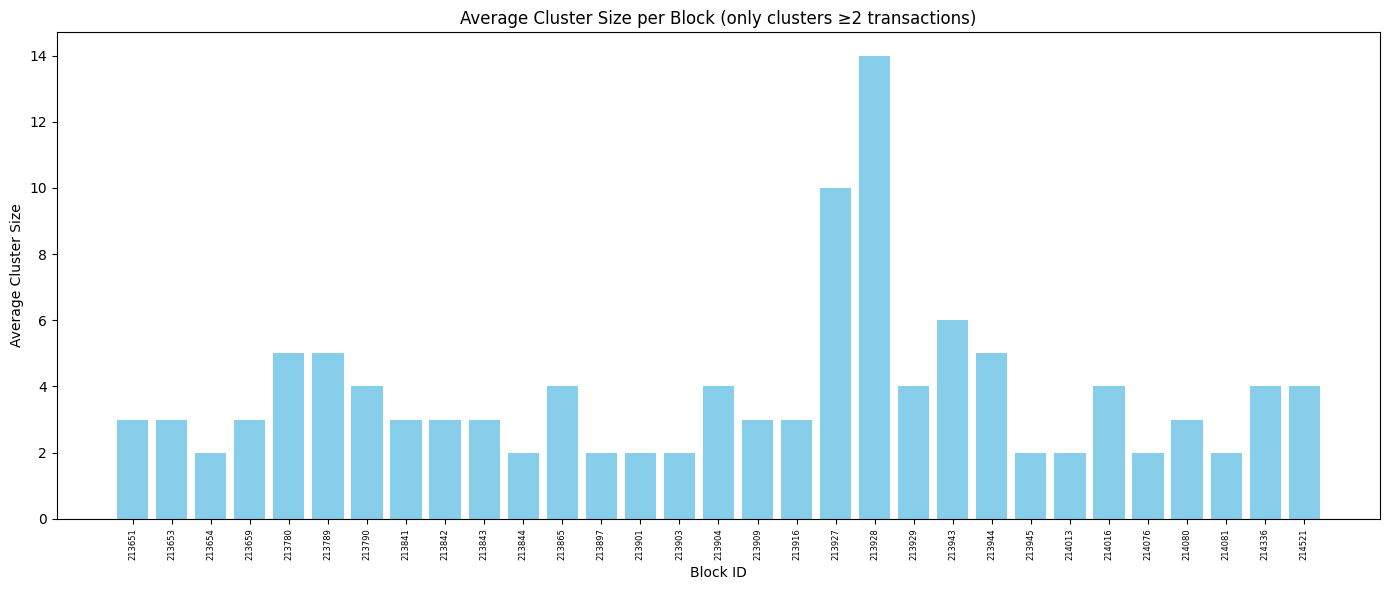

In [24]:
# If the DataFrame 'all_clusters' is not empty, proceed with the analysis
if not all_clusters.empty:
    # Filter only clusters with at least 2 transactions
    filtered_clusters = all_clusters[all_clusters['num_transactions'] >= 2]

    # Calculate the average cluster size per block
    avg_cluster_size_per_block = (
        filtered_clusters
        .groupby('blockId')['num_transactions']
        .mean()
        .reset_index()
        .rename(columns={'num_transactions': 'average_cluster_size'})
    )

    # Print the number of blocks and show the first 5 rows of the result
    print("Number of blocks with clusters of at least 2 transactions:", len(avg_cluster_size_per_block))    
    # Plot the average cluster size per block as a bar chart
    plt.figure(figsize=(14, 6))
    plt.bar(
        avg_cluster_size_per_block['blockId'].astype(str),
        avg_cluster_size_per_block['average_cluster_size'],
        color='skyblue'
    )

    # Optimize x-axis labels for readability
    plt.xticks(rotation=90, fontsize=6, ha='center')
    plt.xlabel('Block ID')
    plt.ylabel('Average Cluster Size')
    plt.title('Average Cluster Size per Block (only clusters ≥2 transactions)')
    plt.tight_layout()
    plt.show()
else:
    print("No clusters found with at least 2 transactions after filtering.")

## 4) Gambler's behaviour analysis

Firstly, the bar chart above shows that in many blocks, especially consecutive ones such as _213789_, _213790_ and _213943_, _213944_, there is a concentrated number of transactions (3–5 per block), suggesting that players tend to participate in intensive gaming sessions. Furthermore, several transaction clusters use different addresses belonging to the same wallet, indicating that players adopt privacy strategies to hide their gaming activity.
In particular, a significant number of gaming transactions are concentrated in blocks _213927_ and _213928_, where all addresses belong to the wallet `0004f784de`, according to information extracted from WalletExplorer. It can be assumed that the player probably engaged in an intensive gaming session in a short period of time, likely in an attempt to recover losses or maximise profits.
The cluster data also shows that numerous transactions originate from the CoinJoin service wallet, as is the case in block _213789_. This service “mixes” decentralised Bitcoin transactions, combining the operations of multiple players in this case, making it more difficult to track individual flows and thus improving individual privacy.
In conclusion, analysis of the DiceOnCrack.com gambling service reveals a complex pattern of player behaviour, characterised by intensive gaming sessions, strategic use of privacy techniques and significant use of CoinJoin services to increase the anonymity of transactions.


---
